In [3]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import numpy as np
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
import torch.functional as F
from io import open
import matplotlib.pyplot as plt
import os
from PIL import Image
import pathlib
import glob
import cv2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

In [4]:
train_path='C:/Users/black/Desktop/FIFTH SEM/mini project/gender_train'
#pred_path='C:/Users/black/Desktop/FIFTH SEM/Data Science/crime_scene_1'
pred_path='C:/Users/black/Desktop/FIFTH SEM/mini project/gender_predict'


In [5]:
train_path_1='C:/Users/black/Desktop/Size/size_train'
#pred_path_1='C:/Users/black/Desktop/FIFTH SEM/Data Science/crime_scene_1'
pred_path_1='C:/Users/black/Desktop/FIFTH SEM/mini project/gender_predict'

In [6]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [7]:
#categories
root_1=pathlib.Path(train_path_1)
classes_1=sorted([j.name.split('/')[-1] for j in root_1.iterdir()])

In [8]:
#CNN Network


class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)    
        output=self.pool(output)   
        output=self.conv2(output)
        output=self.relu2(output)  
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        output=output.view(-1,32*75*75)  
        output=self.fc(output)
            
        return output
            
        


In [11]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
checkpoint=torch.load('best_checkpoint_gender.model')
model=ConvNet(num_classes=6)
model.load_state_dict(checkpoint)
model.eval()

def evaluate_model(model, test_loader):
    model.eval()
    true_labels = []
    predictions = []

    for images, labels in test_loader:
        if torch.cuda.is_available():
            images = images.cuda()

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        true_labels += labels.tolist()
        predictions += predicted.tolist()

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    conf_matrix = confusion_matrix(true_labels, predictions)

    return accuracy, f1, recall, conf_matrix

# Evaluation for Classifier 1
accuracy_1, f1_1, recall_1, conf_matrix_1 = evaluate_model(model, test_loader)

print("Classifier 1 Metrics:")
print(f"Accuracy: {accuracy_1}")
print(f"F1 Score: {f1_1}")
print(f"Recall: {recall_1}")
print("Confusion Matrix:")
print(conf_matrix_1)

NameError: name 'test_loader' is not defined

In [8]:
checkpoint_1=torch.load('best_checkpoint_size.model')
model_1=ConvNet(num_classes=6)
model_1.load_state_dict(checkpoint_1)
model_1.eval()

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=180000, out_features=6, bias=True)
)

In [9]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [10]:
#prediction function
def prediction(img_path,transformer):
    
    image=Image.open(img_path)
    
    image_tensor=transformer(image).float()
    
    
    image_tensor=image_tensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image_tensor.cuda()
        
    input=Variable(image_tensor)
    
    
    output=model(input)
    
    index=output.data.numpy().argmax()
    
    pred=classes[index]
    
    return pred
    


In [11]:
#prediction function
def prediction_1(img_path,transformer):
    
    image=Image.open(img_path)
    
    image_tensor=transformer(image).float()
    
    
    image_tensor=image_tensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image_tensor.cuda()
        
    input=Variable(image_tensor)
    
    
    output=model(input)
    
    index=output.data.numpy().argmax()
    
    pred_1=classes_1[index]
    
    return pred_1
    


In [12]:
images_path=glob.glob(pred_path+'/*.tiff')

In [13]:
images_path_1=glob.glob(pred_path_1+'/*.tiff')

In [14]:
pred_dict={}

for i in images_path:
    pred_dict[i[i.rfind('/')+1:]]=prediction(i,transformer)

In [15]:
pred_dict_1={}

for i in images_path_1:
    pred_dict_1[i[i.rfind('/')+1:]]=prediction_1(i,transformer)

In [16]:
pred_dict

{'gender_predict\\Male.tiff': 'men',
 'gender_predict\\Male1.tiff': 'women',
 'gender_predict\\Male2.tiff': 'men',
 'gender_predict\\Male3.tiff': 'men',
 'gender_predict\\Male4.tiff': 'men',
 'gender_predict\\Male5.tiff': 'men',
 'gender_predict\\Women.tiff': 'women',
 'gender_predict\\Women1.tiff': 'women',
 'gender_predict\\Women2.tiff': 'men',
 'gender_predict\\Women3.tiff': 'women',
 'gender_predict\\Women4.tiff': 'women',
 'gender_predict\\Women5.tiff': 'women',
 'gender_predict\\Women6.tiff': 'women',
 'gender_predict\\Women7.tiff': 'women'}

In [17]:
pred_dict_1

{'gender_predict\\Male.tiff': 'size10',
 'gender_predict\\Male1.tiff': 'size11',
 'gender_predict\\Male2.tiff': 'size10',
 'gender_predict\\Male3.tiff': 'size10',
 'gender_predict\\Male4.tiff': 'size10',
 'gender_predict\\Male5.tiff': 'size10',
 'gender_predict\\Women.tiff': 'size11',
 'gender_predict\\Women1.tiff': 'size11',
 'gender_predict\\Women2.tiff': 'size10',
 'gender_predict\\Women3.tiff': 'size11',
 'gender_predict\\Women4.tiff': 'size11',
 'gender_predict\\Women5.tiff': 'size11',
 'gender_predict\\Women6.tiff': 'size11',
 'gender_predict\\Women7.tiff': 'size11'}

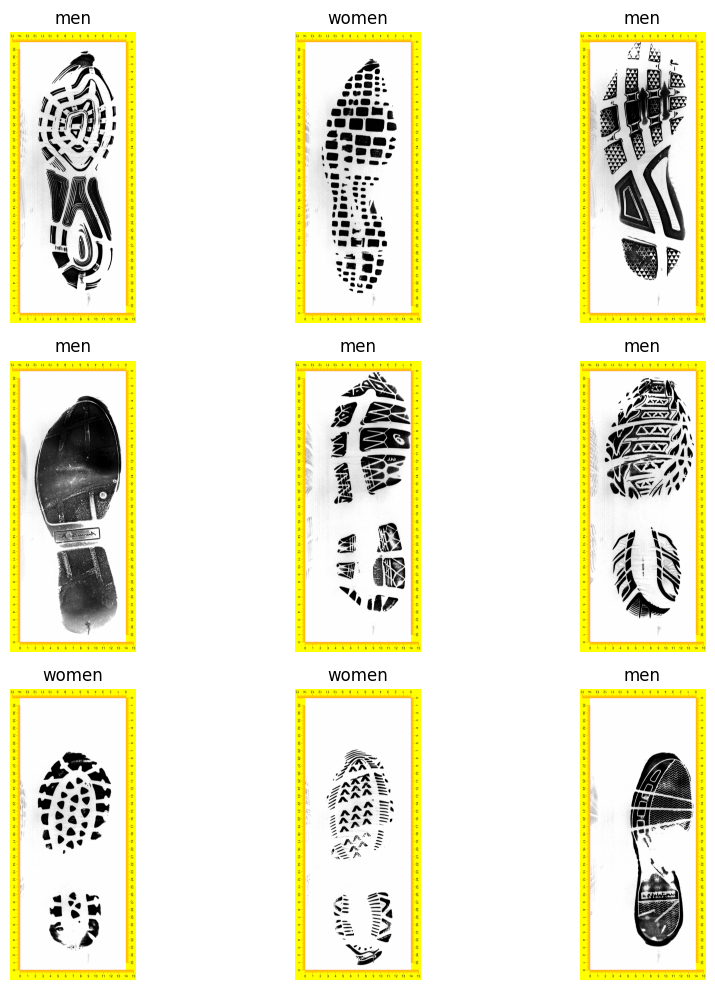

In [24]:
# ... (previous code remains unchanged)

# Replace your current loop with this updated loop to plot images with predicted labels
fig = plt.figure(figsize=(10, 10))

num_images = min(len(images_path), 9)  # Limit the number of images to 9 for a 3x3 grid

for i, img_path in enumerate(images_path[:num_images], 1):
    pred_label = prediction(img_path, transformer)
    
    # Load image using OpenCV for display
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR by default, convert it to RGB
    
    # Plot the image
    ax = fig.add_subplot(3, 3, i)
    ax.imshow(img)
    ax.set_title(pred_label)
    ax.axis('off')

plt.tight_layout()
plt.show()



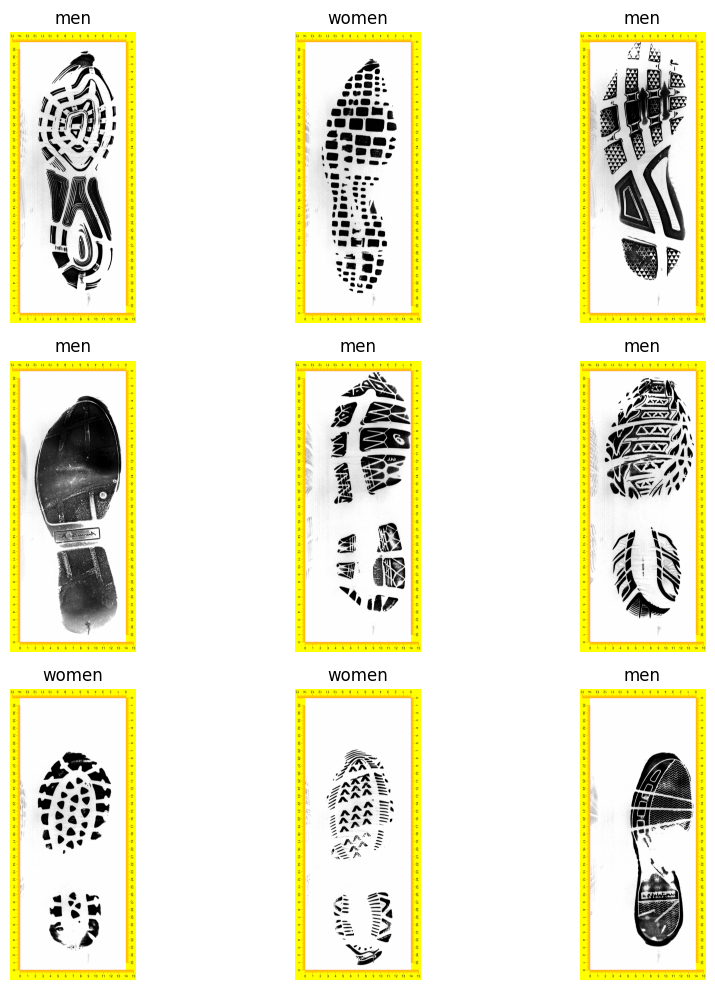

In [19]:
fig = plt.figure(figsize=(10, 10))

num_images = min(len(images_path), 9)

for i, img_path in enumerate(images_path[:num_images], 1):
    pred_label = prediction(img_path, transformer)
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ax = fig.add_subplot(3, 3, i)
    ax.imshow(img)
    ax.set_title(pred_label)
    ax.axis('off')

plt.tight_layout()
plt.show()


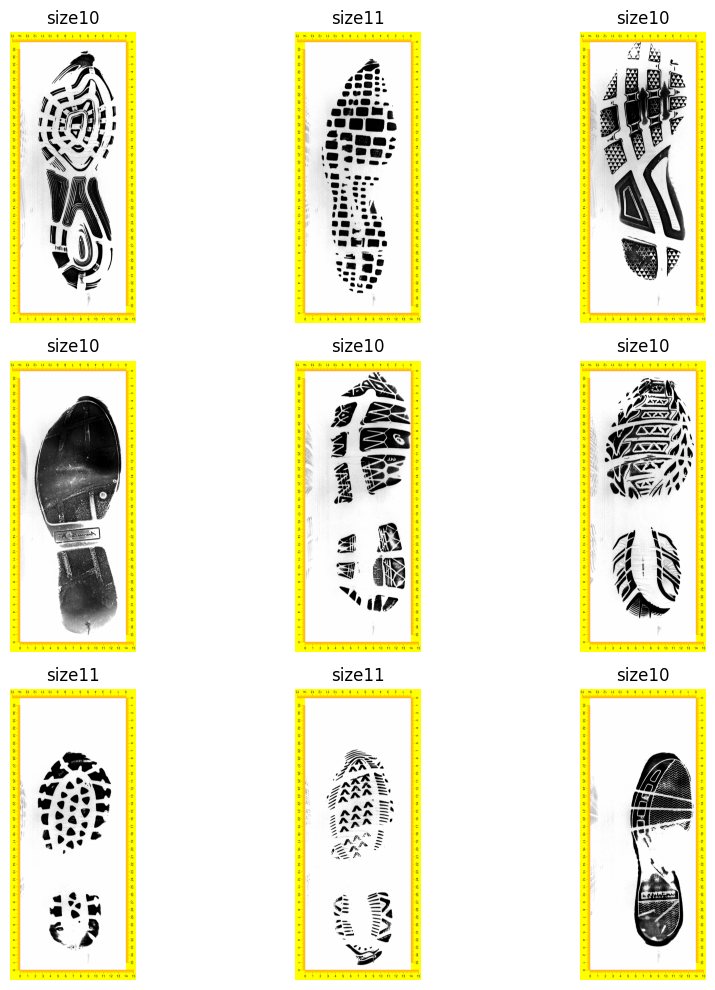

In [20]:
fig = plt.figure(figsize=(10, 10))

num_images = min(len(images_path), 9)

for i, img_path_1 in enumerate(images_path_1[:num_images], 1):
    pred_label = prediction_1(img_path_1, transformer)
    
    img = cv2.imread(img_path_1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ax = fig.add_subplot(3, 3, i)
    ax.imshow(img)
    ax.set_title(pred_label)
    ax.axis('off')

plt.tight_layout()
plt.show()


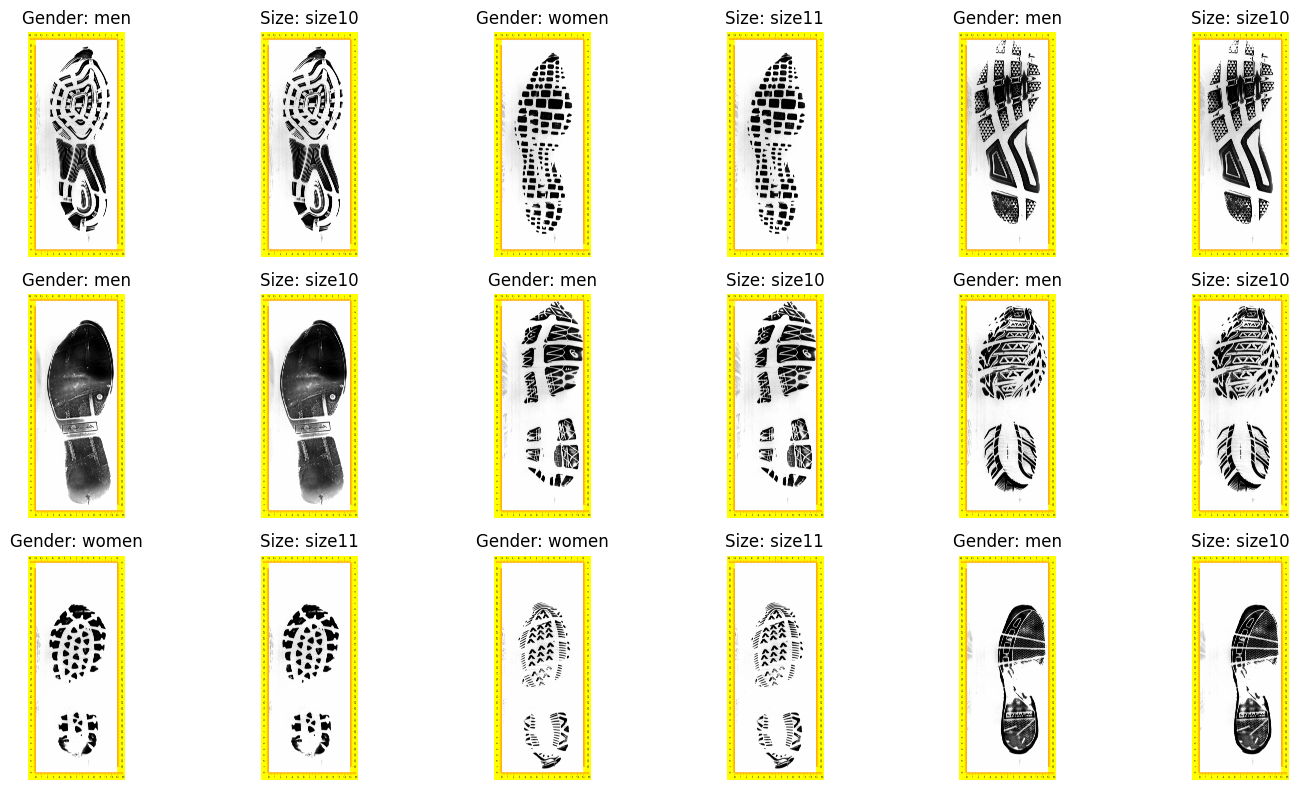

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(15, 8))  # Creating a 3x6 grid for both classifiers

num_images = min(len(images_path), 9)  # Display predictions for up to 9 images (2 per classifier)

for i, img_path in enumerate(images_path[:num_images], 1):
    pred_label1 = prediction(img_path, transformer)
    pred_label2 = prediction_1(img_path, transformer)
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    row = (i - 1) // 3  # Calculate the row index based on the current image and layout
    col = 2 * ((i - 1) % 3)  # Calculate the starting column index
    
    ax = axes[row, col]  # First column for predictions from classifier 1
    ax.imshow(img)
    ax.set_title(f'Gender: {pred_label1}')
    ax.axis('off')
    
    ax = axes[row, col + 1]  # Second column for predictions from classifier 2
    ax.imshow(img)
    ax.set_title(f'Size: {pred_label2}')
    ax.axis('off')

plt.tight_layout()
plt.show()


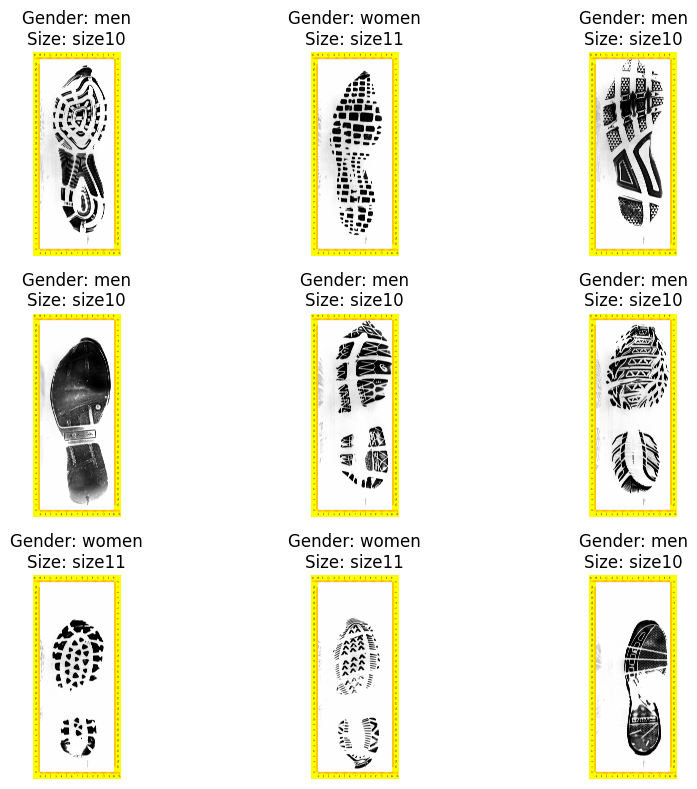

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))  # Creating a 3x6 grid for both classifiers

num_images = min(len(images_path), 9)  # Display predictions for up to 9 images (2 per classifier)

for i, img_path in enumerate(images_path[:num_images], 1):
    pred_label1 = prediction(img_path, transformer)
    pred_label2 = prediction_1(img_path, transformer)
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    row = (i - 1) // 3  # Calculate the row index based on the current image and layout
    col = (i - 1) % 3  # Calculate the starting column index
    
    combined_label = f'Gender: {pred_label1}\nSize: {pred_label2}'  # Combine both labels
    
    ax = axes[row, col]  # Plotting on the respective axis
    ax.imshow(img)
    ax.set_title(combined_label)
    ax.axis('off')

plt.tight_layout()
plt.show()
